torch.nn
    Module: 
    Parameter: 역전파 때 업데이트 해줄 필요가 있는 가중치, requires_grad 속성이 있는 Tensor 형태
    functional: activation functions, loss functions, etc
torch.optim: optimizer(SGD, etc): 역전파때 Parameter의 가중치를 업데이트함(optimizer.step())
Dataset: train_ds = TensorDataset(x_train,y_train)  # 학습데이터와 정답레이블을 묶어주는 역할 zip()과 비슷
DataLoader:    train_dl = DataLoader(train_ds, batch_size=batch_size)   # Dataset의 데이터를 배치 사이즈로 나눠주는 역할

In [75]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

In [76]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [77]:
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(50000, 784) (50000,) (10000, 784) (10000,)


(50000, 784)


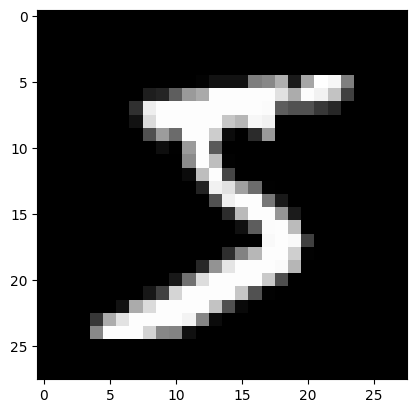

In [78]:
from matplotlib import pyplot
import numpy as np

# x_train[0].reshape(28,28) : 한 줄짜리를 28 x 28로 바꿔줌
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [79]:
import torch

x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

In [80]:
n,c = x_train.shape
x_train.shape

torch.Size([50000, 784])

In [86]:
# weight, bias 정의
import math
# 784 차원을 10개로 분류, 루트784로 나누는 이유는 사비에르 초기값 적용
weight = torch.randn(784,10) / math.sqrt(784)
weight.requires_grad_()
bias = torch.zeros(10,requires_grad=True)

In [87]:
def log_softmax(x):
    return x-x.exp().sum(-1).log().unsqueeze(-1)

# @ 연산은 행렬 곱 연산을 뜻한다.
def model(xb):
    return log_softmax(xb @ weight + bias)

In [83]:
batch_size = 64

xb = x_train[0:batch_size]      # 0~ batch size 만큼 선택
preds = model(xb)       # 하나의 계층 통과
preds[0], preds.shape       # 배치 데이터 각각에 대해 10개의 값이 나온다.

(tensor([-2.5801, -2.0607, -2.1377, -2.1174, -2.2982, -2.3740, -2.2868, -2.5343,
         -3.1042, -1.9713], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [12]:
# loss function
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

In [13]:
yb = y_train[0:batch_size]
loss_func(preds,yb)

tensor(2.3817, grad_fn=<NegBackward0>)

In [14]:
def accuracy(out,yb):
    pred = torch.argmax(out, dim=1)
    return (pred == yb).float().mean()  # float 형으로 바꿔줘야 한다. 전체분의 맞춘개수이므로 mean()으로 계산해도 된다.

In [16]:
accuracy(preds,yb)

tensor(0.0781)

In [17]:
# training loop
# 각각의 iteration마다
# 1. 배치 선택
# 2. 예측 모델 사용
# 3. 손실 계산
# 4. 손실 역전파 => weight, bias 기울기 계산

In [90]:
from IPython.core.debugger import set_trace
from torch import nn
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1)//batch_size + 1):    # iteration
        start_i = batch_size * i
        xb = x_train[start_i:start_i+batch_size]
        yb = y_train[start_i:start_i+batch_size]
        pred = model(xb)        # dense
        loss = nn.functional.cross_entropy(pred,yb)
        print(loss)
        loss.backward() # grad 계산
        
        # optimizer.step()
        with torch.no_grad():
            weight -= weight.grad * lr
            bias -= bias.grad * lr
            weight.grad.zero_()
            bias.grad.zero_()

tensor(0.2327, grad_fn=<NllLossBackward0>)
tensor(0.1993, grad_fn=<NllLossBackward0>)
tensor(0.4195, grad_fn=<NllLossBackward0>)
tensor(0.3081, grad_fn=<NllLossBackward0>)
tensor(0.3671, grad_fn=<NllLossBackward0>)
tensor(0.0978, grad_fn=<NllLossBackward0>)
tensor(0.1838, grad_fn=<NllLossBackward0>)
tensor(0.4550, grad_fn=<NllLossBackward0>)
tensor(0.1919, grad_fn=<NllLossBackward0>)
tensor(0.3842, grad_fn=<NllLossBackward0>)
tensor(0.3328, grad_fn=<NllLossBackward0>)
tensor(0.1988, grad_fn=<NllLossBackward0>)
tensor(0.2857, grad_fn=<NllLossBackward0>)
tensor(0.5281, grad_fn=<NllLossBackward0>)
tensor(0.3998, grad_fn=<NllLossBackward0>)
tensor(0.2695, grad_fn=<NllLossBackward0>)
tensor(0.6208, grad_fn=<NllLossBackward0>)
tensor(0.6421, grad_fn=<NllLossBackward0>)
tensor(0.0788, grad_fn=<NllLossBackward0>)
tensor(0.5617, grad_fn=<NllLossBackward0>)
tensor(0.3544, grad_fn=<NllLossBackward0>)
tensor(0.6653, grad_fn=<NllLossBackward0>)
tensor(0.2293, grad_fn=<NllLossBackward0>)
tensor(0.28

In [91]:
(loss_func(model(xb), yb), accuracy(model(xb), yb))

(tensor(0.0653, grad_fn=<NegBackward0>), tensor(1.))

Using torch.nn.functional

In [41]:
# torch nn funtion을 사용하여 구현하기

from torch import nn

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
    
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [42]:
model = Model()
loss_func(model(xb),yb)

tensor(-0.1079, grad_fn=<NegBackward0>)

In [43]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0348, -0.0694, -0.0289,  ...,  0.0099, -0.0042, -0.0016],
         [ 0.0402, -0.0054,  0.0370,  ...,  0.0058, -0.0139,  0.0661],
         [-0.0296,  0.0139, -0.0487,  ...,  0.0058, -0.0326, -0.0093],
         ...,
         [ 0.0045,  0.0022, -0.0045,  ..., -0.0609, -0.0022,  0.0064],
         [-0.0395, -0.0027, -0.0101,  ..., -0.0077,  0.0101,  0.0279],
         [-0.0221, -0.0051, -0.0802,  ...,  0.0321,  0.0201,  0.0324]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [45]:
lr = torch.tensor(0.01,dtype=torch.float)
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

In [47]:
nn.functional.sigmoid(torch.tensor(0.5))

c:\Users\DILAB\anaconda3\envs\DL\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.6225)

In [61]:
x_train = torch.randn(100,10)
y_train = torch.randint(10,(100,))
y_train

tensor([3, 5, 4, 6, 8, 4, 6, 9, 8, 6, 0, 3, 8, 2, 6, 2, 4, 1, 6, 9, 9, 5, 9, 4,
        9, 1, 8, 8, 8, 4, 2, 7, 4, 8, 3, 7, 5, 9, 4, 8, 3, 8, 3, 1, 1, 5, 2, 5,
        2, 0, 5, 9, 8, 1, 1, 2, 1, 1, 3, 2, 9, 1, 6, 8, 4, 5, 3, 9, 9, 1, 4, 1,
        5, 7, 1, 1, 7, 8, 1, 6, 1, 2, 9, 7, 4, 8, 9, 2, 3, 5, 1, 4, 0, 1, 8, 2,
        9, 6, 4, 4])

In [97]:
# nn.functional.cross_entropy(predicion, label) 바로 계산
# nn.CrossEntropyLoss() : 객체 생성
loss = nn.CrossEntropyLoss()
input = torch.randn(3,5, requires_grad=True)
target = torch.empty(3,dtype=torch.long).random_(5)
# print(target)
output = loss(input, target)
output.backward()
output

tensor(1.3276, grad_fn=<NllLossBackward0>)

In [142]:
# nn.functional. 하면 바로 사용하는 것
# nn.대문자() : 클래스로서 객체 생성
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784,10)     # 기울기는 .weight.grad에 저장됨
        # self.bias1 = torch.zeros(50)
        # self.sig1 = nn.Sigmoid()
        # self.layer2 = nn.Linear(50,10)     # 기울기는 .weight.grad에 저장됨
        self.bias2 = torch.zeros(10)
        self.softmax = nn.Softmax()
        self.loss = nn.CrossEntropyLoss()
        
    def forward(self,x):
        x = self.layer1(x) + self.bias2
        # x = self.sig1(x)
        # x = self.layer2(x) + self.bias2
        # x = self.softmax(x)
        return x
    
    def fit(self):
        for epoch in range(epochs):
            for i in range((n-1)//batch_size + 1):
                start_idx =  batch_size*i
                end_idx = start_idx + batch_size
                xs = x_train[start_idx:end_idx]
                ys = y_train[start_idx:end_idx]
                pred = mymodel(xs)
                output = self.loss(pred,ys)
                print(output)
                output.backward()
                with torch.no_grad():
                    for p in mymodel.parameters():
                        p -= p.grad * lr
                        mymodel.zero_grad()

In [145]:
lr = torch.tensor(0.5)
epochs = 10
mymodel = Model()
mymodel.fit()
# epoch를 늘려도 손실은 줄지 않고, sigmoid함수나 linear계층을 쌓는건 오히려 방해가 된다.
# 어떻게 해야 손실을 줄일 수 있을까?
# 이게 분류 문제이기에 크로스엔트로피 손실 함수를 사용하는 것은 맞다.

c:\Users\DILAB\anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(2.3038, grad_fn=<NllLossBackward0>)
tensor(2.2924, grad_fn=<NllLossBackward0>)
tensor(2.2928, grad_fn=<NllLossBackward0>)
tensor(2.2745, grad_fn=<NllLossBackward0>)
tensor(2.2639, grad_fn=<NllLossBackward0>)
tensor(2.2609, grad_fn=<NllLossBackward0>)
tensor(2.2365, grad_fn=<NllLossBackward0>)
tensor(2.2240, grad_fn=<NllLossBackward0>)
tensor(2.2308, grad_fn=<NllLossBackward0>)
tensor(2.2162, grad_fn=<NllLossBackward0>)
tensor(2.1834, grad_fn=<NllLossBackward0>)
tensor(2.1998, grad_fn=<NllLossBackward0>)
tensor(2.1614, grad_fn=<NllLossBackward0>)
tensor(2.1414, grad_fn=<NllLossBackward0>)
tensor(2.1362, grad_fn=<NllLossBackward0>)
tensor(2.0971, grad_fn=<NllLossBackward0>)
tensor(2.1307, grad_fn=<NllLossBackward0>)
tensor(2.1292, grad_fn=<NllLossBackward0>)
tensor(2.0583, grad_fn=<NllLossBackward0>)
tensor(2.1091, grad_fn=<NllLossBackward0>)
tensor(2.0637, grad_fn=<NllLossBackward0>)
tensor(2.0276, grad_fn=<NllLossBackward0>)
tensor(2.0361, grad_fn=<NllLossBackward0>)
tensor(1.98

In [156]:
class Model_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
    def forward(self, x):
        return self.lin(x)

In [157]:
print(xb.shape, yb.shape)

torch.Size([16, 784]) torch.Size([16])


In [159]:
my_model = Model_2()
print(my_model(xb).shape,yb.shape)
nn.functional.cross_entropy(my_model(xb),yb)

torch.Size([16, 10]) torch.Size([16])


tensor(2.3179, grad_fn=<NllLossBackward0>)

In [153]:
x = torch.randn(100,6)
y = torch.randint(6,(100,))
y.shape

torch.Size([100])

In [160]:
nn.functional.cross_entropy(x,y)

tensor(1.9921)

In [161]:
# 손수 이렇게 할 필요없이 torch.optim 메소드로 편하게 구현할 수 있다.
with torch.no_grad():
    for p in my_model.parameters(): p -= p.grad * lr
    my_model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Tensor'

In [162]:
# 단지 요런식으로
opt.step()
opt.zero_grad()

TypeError: 'module' object is not callable

In [166]:
# 범위를 넘어도 되는구나.
xb[:20].shape

torch.Size([16, 784])

In [169]:
from torch import optim
def get_model():
    model = Model_2()
    return model, optim.SGD(model.parameters(), lr=lr)
model, opt = get_model()
print('첫배치 손실 =',nn.functional.cross_entropy(model(xb),yb))

for epoch in range(epochs):
    # for i in range(0,xb.shape[0],batch_size): 딱 떨어지는 거 아니면 마지막 부분을 돌지 못한다.
    for i in range((n-1)//batch_size + 1):      # 데이터 개수 / 배치 사이즈 = iter
        start_i = i*batch_size
        end_i = start_i + batch_size
        xs = x_train[start_i:end_i]
        ys = y_train[start_i:end_i]
        pred = model(xs)
        loss = nn.functional.cross_entropy(pred,ys)
        loss.backward() # 기울기 구함
        opt.step()  # 기울기 적용
        opt.zero_grad()     # 기울기 0으로 초기화 (다음 미니배치 전에 초기화해줄 필요가 있다.)
print('학습 후 손실=',nn.functional.cross_entropy(pred,ys))
        
        

첫배치 손실 = tensor(2.2438, grad_fn=<NllLossBackward0>)
학습 후 손실= tensor(0.1665, grad_fn=<NllLossBackward0>)


In [ ]:
# Dataset
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train,y_train)

# 이전엔 이렇게 했지만 
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

# 이제는 이렇게 간단히 쓸 수 있다.
xb,yb = train_ds[i*batch_size:i*batch_size+batch_size]

model,opt = get_model()    

for epoch in range(epochs):
    for i in range((n-1)//batch_size + 1):
        start_i = i*batch_size
        end_i = start_i + batch_size
        xs = x_train[start_i:end_i] # 배치
        ys = y_train[start_i:end_i]
        pred = model(xs)    # 예측값
        # pred = nn.functional.softmax(pred)    # 왜 소프트맥스가 없어야 손실이 더 적게 날까?
        loss = nn.functional.cross_entropy(pred,ys) # 손실
        loss.backward() # 손실 기울기
        opt.step()  # 기울기 적용
        opt.zero_grad() # 기울기 초기화
print(nn.functional.cross_entropy(pred,ys))

In [180]:
# DataLoader 를 사용해서 iter와 mini batch를 좀더 쉽게 만들 수 있다.

from torch.utils.data import DataLoader

# TensorDataset은 학습과 정답 데이터 셋을 뭉쳐주고 분배하는 역할
train_ds = TensorDataset(x_train,y_train)
print(x_train.shape,y_train.shape)
print(train_ds)
# DataLoader는 TensorDataset객체에 대해 배치사이즈로 나눠주는 역할
train_dl = DataLoader(train_ds, batch_size=batch_size)
train_dl.batch_size

torch.Size([50000, 784]) torch.Size([50000])


64

In [173]:
# 이전에 이렇게 했다면
for i in range((n-1)//batch_size + 1):
    xb, yb = train_ds[i*batch_size:i*batch_size+batch_size]
    pred = model(xb)

In [174]:
# 이제는 좀더 깔끔하게 다음과 같이 쓸 수 있다.
for xb,yb in train_dl:
    pred = model(xb)
# 왜냐하면 이미 DataLoader로 인해 배치사이즈로 나눠놨기 때문!

In [178]:
# Add validation

# validation set으로 오버피팅을 확인해야 한다.
# 학습 데이터를 섞는 것은 배치와 오버피팅 간의 상관관계를 막는데 중요하다.
# 반면에 validation loss는 validation set을 섞든 안섞든 동일하다.
# 따라서 validation은 shuffling하지 않겠다.
# validation batch size는 training set의 batch size보다 2배 크다.
# 왜냐하면 validation batch size는 역전파를 진행하지 않기 때문이다.
# 따라서 기울기를 저장하지 않기 때문에 메모리가 덜 필요하다.
# 이러한 점을 사용하여 validation은 더 큰 배치사이즈를 이용하고 loss를 좀더 빠르게 게산할 수 있다.

In [181]:
train_ds = TensorDataset(x_train,y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

valid_ds = TensorDataset(x_valid,y_valid)
valid_dl = DataLoader(valid_ds, batch_size=batch_size*2)

In [182]:
model = Model_2()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = torch.nn.functional.cross_entropy(pred,yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(torch.nn.functional.cross_entropy(model(xb),yb) for xb,yb in valid_dl)
    print(epoch, valid_loss/len(valid_dl))  # len(valid_dl) : 배치사이즈가 몇개로 나누어졌는가? totaldata/batchsize

0 tensor(1.6962)
1 tensor(1.3256)
2 tensor(1.1042)
3 tensor(0.9621)
4 tensor(0.8641)
5 tensor(0.7927)
6 tensor(0.7382)
7 tensor(0.6953)
8 tensor(0.6605)
9 tensor(0.6317)


In [185]:
# optimizer로 Adam을 사용하면서 복습하기
model = Model_2()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = torch.nn.functional.cross_entropy(pred,yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    model.eval()
    with torch.no_grad():
        valid_loss = sum(torch.nn.functional.cross_entropy(model(xs),ys) for xs,ys in valid_dl)
    print(epoch, valid_loss/len(valid_dl))  # sum 했으므로 배치개수만큼 나눠줘야 한다.

0 tensor(0.3350)
1 tensor(0.2916)
2 tensor(0.2750)
3 tensor(0.2661)
4 tensor(0.2624)
5 tensor(0.2590)
6 tensor(0.2591)
7 tensor(0.2537)
8 tensor(0.2538)
9 tensor(0.2531)


In [186]:
# fit(), get_data()
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb),yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

In [213]:
from  torch.utils.data import DataLoader
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred= model(xb)
            loss = loss_func(pred,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model,loss_func,xb,yb) for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums))/np.sum(nums)
        print(epoch, val_loss)

In [199]:
a,b = zip((1.5,3),(1,3)) # == zip(*[(1.5,3),(1,3)])
a,b

((1.5, 1), (3, 3))

In [198]:
a,b = zip([(1.5,3),(1,3)],)
a,b

(((1.5, 3),), ((1, 3),))

In [202]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_dl, batch_size=batch_size*2)
    )

In [214]:
from torch.utils.data import DataLoader
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model,opt = get_model()
fit(epochs,model,torch.nn.functional.cross_entropy,opt,train_dl,valid_dl)

TypeError: 'DataLoader' object is not subscriptable

In [205]:
# CNN

In [209]:
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16,16,kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16,10,kernel_size=3,stride=2,padding=1)
        
    def forward(self,x):
        x = x.view(-1,1,28,28)      # 이미지 개수, 채널수, 너비, 높이
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.avg_pool2d(x,4)   # 평균 풀링(4,4)
        return x.view(-1,x.size(1))     # flatten

In [210]:
lr = 0.1

In [215]:
cnn = CNN()
opt = optim.SGD(cnn.parameters(), lr=lr)
loss_func = torch.nn.CrossEntropyLoss()
fit(epochs, cnn, loss_func, opt, train_dl, valid_dl)

TypeError: 'DataLoader' object is not subscriptable

In [216]:
class Lambda(nn.Module):
    def __init__(self,func):
        super(Lambda,self).__init__()
        self.func = func
    def forward(self,x):
        return self.func(x)
def preprocess(x):
    return x.view(-1,1,28,28)
    

In [217]:
model = nn.Sequential(Lambda(preprocess),
                      nn.Conv2d(1,16,kernel_size=3,stride=2,padding=1),
                      nn.ReLU(),
                      nn.Conv2d(16,16,kernel_size=3,stride=2,padding=1),
                      nn.ReLU(),
                      nn.Conv2d(16,10,kernel_size=3,stride=2,padding=1),
                      nn.ReLU(),
                      nn.AvgPool2d(4),
                      Lambda(lambda x : x.view(x.size(0),-1))
)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_func = torch.nn.CrossEntropyLoss()
fit(epochs, model, loss_func,opt,train_dl,valid_dl)

TypeError: 'DataLoader' object is not subscriptable

In [218]:
print(torch.cuda.is_available())

False
